In [1]:
# Importing dependencies
from IPython.display import Image, Audio
import scipy.io
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import mne

# Logistic regression classification of interaction with human and interaction with computer conditions

Successful social interactions rely on the abilities of two or more people to mutually exchange information in
real-time, while simultaneously adapting to one another. But the underlying neural mechanisms remain unknown. In an EEG experiment, we wanted to better understand the neural mechanisms when we engage in interaction with another person, versus with a computer. We thus aimed to predict whether the brain data (recorded with EEG) originated from an experimental condition where participants engaged in interaction with another person, or with a non-responsive computer. The participants were recruited in pairs, and asked to finger tap to a given beat, which would then cease, and they would hear either the other person (interacting with human), or the computer (interaction with computer). Their task was to sycnhronize with their auditory feedback (other person or computer). The other person was thus adaptable, while the computer was not. The computer condition in this experiment was also a metronome, thus not variable. The two experimental conditions are illustrated below.

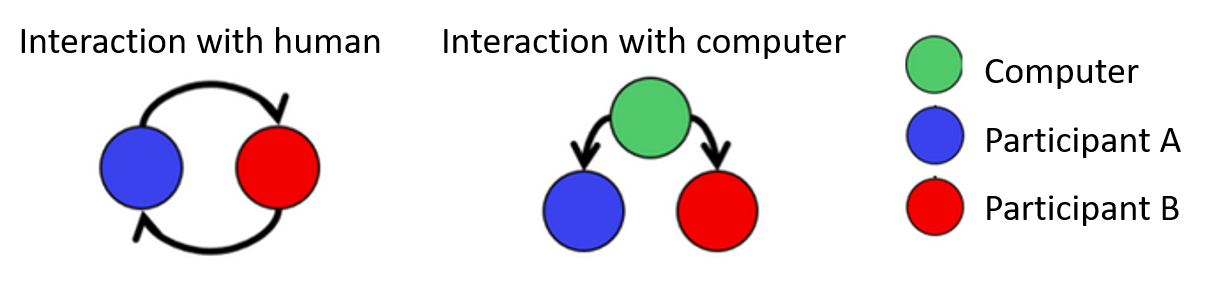

In [2]:
Image("conditions.png",width=700)

EEG data are known to be highly contaminated with noise (artefacts typically originating from muscle and eye movements). Therefore, the given EEG data are already pre-processed, and they represent the 10 Hz power estimates for each electrode (of each person in a pair) for each of the trials. The number of trials is the length of the vector $y$. Power is the squared value of the amplitude of the signal. The data contains power estimates from 60 EEG channels, where 30 belong to participant A and 30 to participant B. This gives a feature matrix $X$, with 60 columns (1 for each feature), and a length the same as the length of the vector $y$. The $y$ vector contains the labels for each trial (1 for the interaction with human condition, 0 for the interaction with computer condition). You have data from 4 pairs (features1.mat, features2.mat, features3.mat, features4.mat, and the corresponding $y$ vectors with condition labels).

In [3]:
# Loading features and labels
feature_mat = scipy.io.loadmat('features1.mat')
y1_mat = scipy.io.loadmat('y1.mat')
features1 = feature_mat['features1']
y1 = np.array(y1_mat['y1'].T[0])
print('The shape of the X feature matrix is: ' + str(features1.shape))
print('The shape of the y vector is: ' + str(y1.shape))

features_files = ['features1.mat', 'features2.mat', 'features3.mat', 'features4.mat']
label_files = ['y1.mat', 'y2.mat', 'y3.mat', 'y4.mat']

n_pairs = len(features_files)

features = []
labels = []

#load features and labels from all pairs
#we store them in lists, because they have different number of trials
for i,feature_f in enumerate(features_files):
    feature_map = scipy.io.loadmat(feature_f)
    y_mat = scipy.io.loadmat(label_files[i])
    idx = str(i+1)
    features.append(feature_map[f'features{idx}'])
    labels.append(np.array(y_mat[f'y{idx}'].T[0]))
    assert features[i].shape[0] == labels[i].shape[0] #ensure same n of trials and labels

The shape of the X feature matrix is: (1573, 60)
The shape of the y vector is: (1573,)


Your task is to predict the conditions of the trials from the EEG data (10 Hz power), using a logistic regression classification. This works by fitting a general linear model with a binomial cost and a logit link function. For additional explanation about the intuition of logistic regression see this [video](https://www.youtube.com/watch?v=yIYKR4sgzI8). The logistic regression classification is fitted with a selected subset of the 60 channels (the 30 channels from each member of the pair are grouped together here). The subset of channels are chosen with sequential feature selection. A 10-fold cross validation loop needs to be implemented as well to accurately assess how well the logistic regression model with sequential feature selection performs. 

#### Exercise 1
Your task is for each cross-validation fold to sequentially find the best number of features/channels and use  them to predict with the logistic regression model and calculate the training and test errors. Additionally, make sure to save the selected features in a list for later visualizations. Build-in functions for logistic regression and sequential feature selection in the scikit learn library might be helpful for your implementation.

##### The implementation step-by-step
> * Initially let's predefine some variables. `K = 10` as we want to divide the data into 10 folds. A variable `tol = 1e-6` which is the minimum improvement to the mean squared error (MSE) required to add an additional feature. Two arrays `test_MSE` and `train_MSE` to store the MSE for training and testing in each fold. We define the cross-validation strategy from `sklearn` as `CV = KFold(K,shuffle=True)` and finally an empty list `sfs_features` is defined to save the features found with sequential feature selection.

> * Now you need to set-up the cross-validation loop. Split the matrix `features1` and the vector `y1` into train and test sets using `CV.split`. For inspiration on how to do this see this [tutorial](https://riptutorial.com/scikit-learn/example/27963/k-fold-cross-validation). Furthermore, the `enumerate()` function might be helpful to keep a count variable of the fold number (e.g. `i`).

> * Use `train_index` and `test_index` from `CV.split()` to index the rows designated for test and training in `features1` and `y1` respectively.

> * Add an additional inner loop through the number of features (i.e. 60) and use [SequentialFeatureSelector()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) from `sklearn` to find the best features. Feed it [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as estimator and set `n_features_to_select` to the loop parameter (e.g. `j`). This way you can add one feature at a time and check if it causes an improvement greater than `tol`. A boolean with the best `j` parameters is found by fitting `SequentialFeatureSelector()` to the training data and then extracted with the methods `.get_support()`.

> * The logistic regression model LogisticRegression() is then fitted to the best features in the training data. This could be done as \
`model = LogisticRegression()` \
`model.fit(X_train[:,sfs.get_support()], y_train)` \
where `sfs` is your `SequentialFeatureSelector()`. 

> * Use your logistic regression model to predict and calculate the mean squared error (MSE) using [mean_squared_error() ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). Now, break the loop if the improvement in the MSE is less than the `tol` variable. If the improvement in MSE is greater than `tol` update a variable storing the best MSE. This variable should be initialized outside the inner loop as an arbitrary large number for example as `best_MSE = 1e3`.

> * Lastly, save training and test MSE for each fold by using the features found with sequential feature selection. Append the boolean of the selected features to the `sfs_features` list. NB! You will need the `sfs_features` list for the exercises next week, where we will visualize and interpret the results.


In [5]:
K = 10
tol = 1e-6 # Minimum MSE improvement required to add an additional feature
test_MSE = np.zeros((n_pairs, K))
train_MSE = np.zeros((n_pairs, K))
CV = KFold(K,shuffle=True, random_state=42) #Select Cross-validation strategy
sfs_features = [[] for x in range(n_pairs)] #for saving the best features for each pair and each fold
    
    
#perform CV for each pair
for p in range(n_pairs):
    X = features[p]
    y = labels[p]
    print(f"\n==============================")
    print(f"Starting pair {p+1}/{n_pairs}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"==============================\n")

    # Cross-validation loop
    for k, (train_index, test_index) in enumerate(CV.split(X)):
        print(f"\nFold {k+1}/{K}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(f"    Training set: {X_train.shape}, Test set: {X_test.shape}")
        

        #initial definitions - arbitrarily large test MSE + empty variable for set of best features
        best_MSE = 1e3
        prev_best = best_MSE
        chosen_features= None
        mse_train_final = None
        mse_test_final = None

        # StandardScaler + LogisticRegression pipeline to normalize data before fitting
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(max_iter=1000))
        ])

        # Sequential Feature Selection loop
        for i in range(1, X.shape[1]+1):
            print(f"Trying with {i} features...")

            # Sequential Feature Selection
            sfs = SequentialFeatureSelector(
                pipe, 
                n_features_to_select=i, 
                direction='forward', 
                scoring='neg_mean_squared_error', 
                cv=3,   # slightly lower for efficiency
                n_jobs=-1
            )
            sfs.fit(X_train, y_train)
            idx = sfs.get_support(indices=True)
            print(f"Selected features so far: {list(idx)}")

            # Train and test with selected features
            pipe.fit(X_train[:,idx], y_train)
            
            # use predict_proba instead of predict for smoother MSE computation
            y_train_pred = pipe.predict_proba(X_train[:,idx])[:,1]
            y_test_pred = pipe.predict_proba(X_test[:,idx])[:,1]
            
            mse_train = mean_squared_error(y_train, y_train_pred)
            mse_test = mean_squared_error(y_test, y_test_pred)
            print(f"MSE (train/test): {mse_train:.6f} / {mse_test:.6f}")

            # Check if the MSE improved enough to add this feature
            improvement = prev_best - mse_test
            if improvement >= tol:
                print(f"Improvement found ({improvement:.2e} >= tol={tol}) keeping feature set")
                prev_best = mse_test
                best_MSE = mse_test
                chosen_features = idx
                mse_train_final = mse_train
                mse_test_final = mse_test
            else:
                print(f"No significant improvement ({improvement:.2e} < tol={tol}) stopping selection")
                # Stop if no significant improvement
                break
        
        # Handle edge case: if no improvement was detected at all
        if mse_test_final is None:
            print("No improvement detected at all; using last feature set.")
            mse_test_final = best_MSE
            mse_train_final = mse_train
            chosen_features = idx
        
        test_MSE[p,k] = mse_test_final
        train_MSE[p,k] = mse_train_final
        sfs_features[p].append(chosen_features)

        print(f"\nFold {k+1} finished.")
        print(f"Best MSE (test): {mse_test_final:.6f}")
        print(f"Selected features: {list(chosen_features)}")

    print(f"\nPair {p+1} completed.")
    print(f"Average test MSE across folds: {np.mean(test_MSE[p]):.6f}")
    print(f"Average number of selected features: {np.mean([len(f) for f in sfs_features[p]]):.2f}")
    print("---------------------------------------------------------------")


Starting pair 1/4
X shape: (1573, 60), y shape: (1573,)


Fold 1/10
    Training set: (1415, 60), Test set: (158, 60)
Trying with 1 features...
Selected features so far: [41]
MSE (train/test): 0.145453 / 0.138291
Improvement found (1.00e+03 >= tol=1e-06) keeping feature set
Trying with 2 features...
Selected features so far: [32, 41]
MSE (train/test): 0.111812 / 0.107882
Improvement found (3.04e-02 >= tol=1e-06) keeping feature set
Trying with 3 features...
Selected features so far: [32, 36, 41]
MSE (train/test): 0.096656 / 0.080311
Improvement found (2.76e-02 >= tol=1e-06) keeping feature set
Trying with 4 features...
Selected features so far: [32, 33, 36, 41]
MSE (train/test): 0.086436 / 0.075585
Improvement found (4.73e-03 >= tol=1e-06) keeping feature set
Trying with 5 features...
Selected features so far: [32, 33, 36, 41, 55]
MSE (train/test): 0.082563 / 0.074369
Improvement found (1.22e-03 >= tol=1e-06) keeping feature set
Trying with 6 features...
Selected features so far: [32,

#### Exercise Part 2

To get a better overview of which features are selected in each cross-validation fold a matrix plot with a row for each feature and a column for each cross-validation fold can be useful.

Plot a matrix of the selected features for each cross validation fold. If there is time, do this for all 4 pairs. 

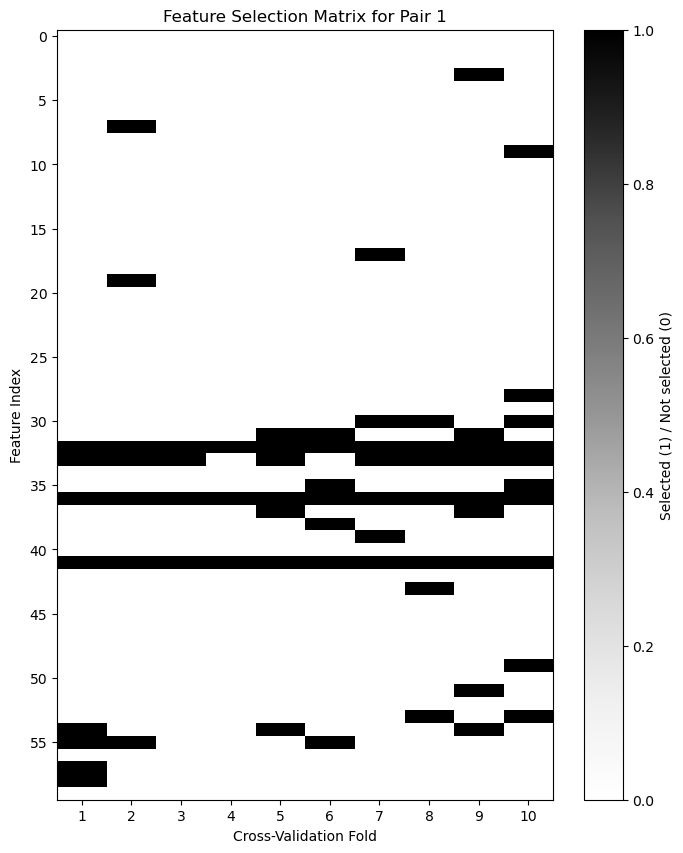

In [9]:
# choose one pair, e.g. p = 0
p = 0
n_features = 60
n_folds = len(sfs_features[p])

# create binary matrix (features x folds)
feature_matrix = np.zeros((n_features, n_folds))

# fill matrix: 1 if feature selected in that fold
for k, idx in enumerate(sfs_features[p]):
    feature_matrix[idx, k] = 1
    
plt.figure(figsize=(8, 10))
plt.imshow(feature_matrix, cmap='Greys', aspect='auto', interpolation='nearest')
plt.colorbar(label='Selected (1) / Not selected (0)')
plt.title(f'Feature Selection Matrix for Pair {p+1}')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Feature Index')
plt.xticks(np.arange(n_folds), np.arange(1, n_folds+1))
plt.yticks(np.arange(0, n_features, 5))
plt.show()


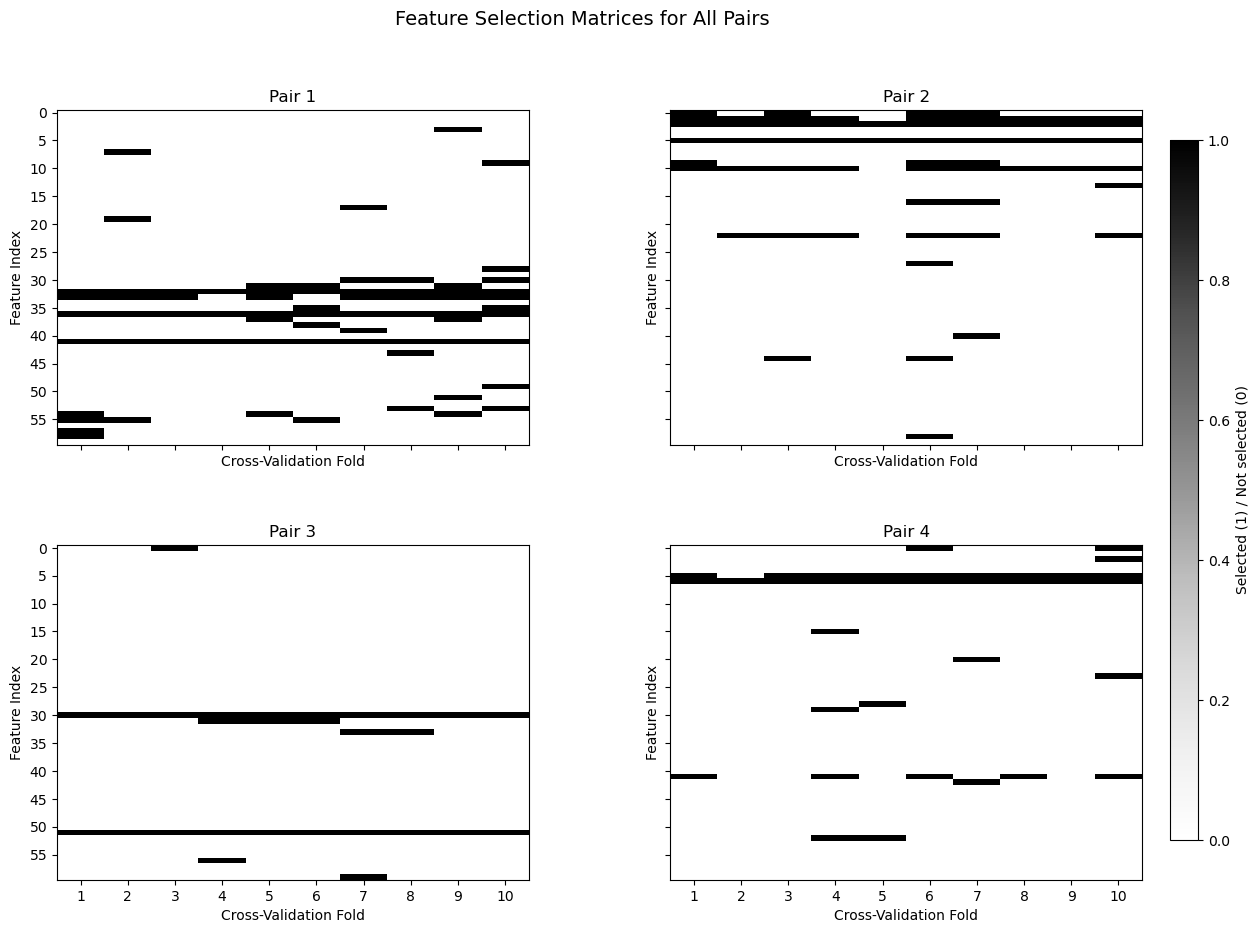

In [18]:
import matplotlib.pyplot as plt
import numpy as np

n_features = 60
n_pairs = len(sfs_features)
rows, cols = 2, 2  # 2x2 grid layout for 4 pairs

fig, axes = plt.subplots(rows, cols, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()  # flatten to iterate easily

for p in range(n_pairs):
    n_folds = len(sfs_features[p])
    feature_matrix = np.zeros((n_features, n_folds))

    # Fill the matrix: 1 if feature was selected in that fold
    for k, idx in enumerate(sfs_features[p]):
        feature_matrix[idx, k] = 1

    ax = axes[p]
    im = ax.imshow(feature_matrix, cmap='Greys', aspect='auto', interpolation='nearest')
    ax.set_title(f'Pair {p+1}', fontsize=12)
    ax.set_xlabel('Cross-Validation Fold')
    ax.set_ylabel('Feature Index')

    # Display numeric tick labels on both axes
    ax.set_yticks(np.arange(0, n_features, 5))
    ax.set_yticklabels(np.arange(0, n_features, 5))
    ax.set_xticks(np.arange(n_folds))
    ax.set_xticklabels(np.arange(1, n_folds + 1))

# Adjust spacing between subplots
fig.subplots_adjust(right=0.9, wspace=0.3, hspace=0.3)

# Add a shared colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
fig.colorbar(im, cax=cbar_ax, label='Selected (1) / Not selected (0)')

# Global title
fig.suptitle('Feature Selection Matrices for All Pairs', fontsize=14)
plt.show()


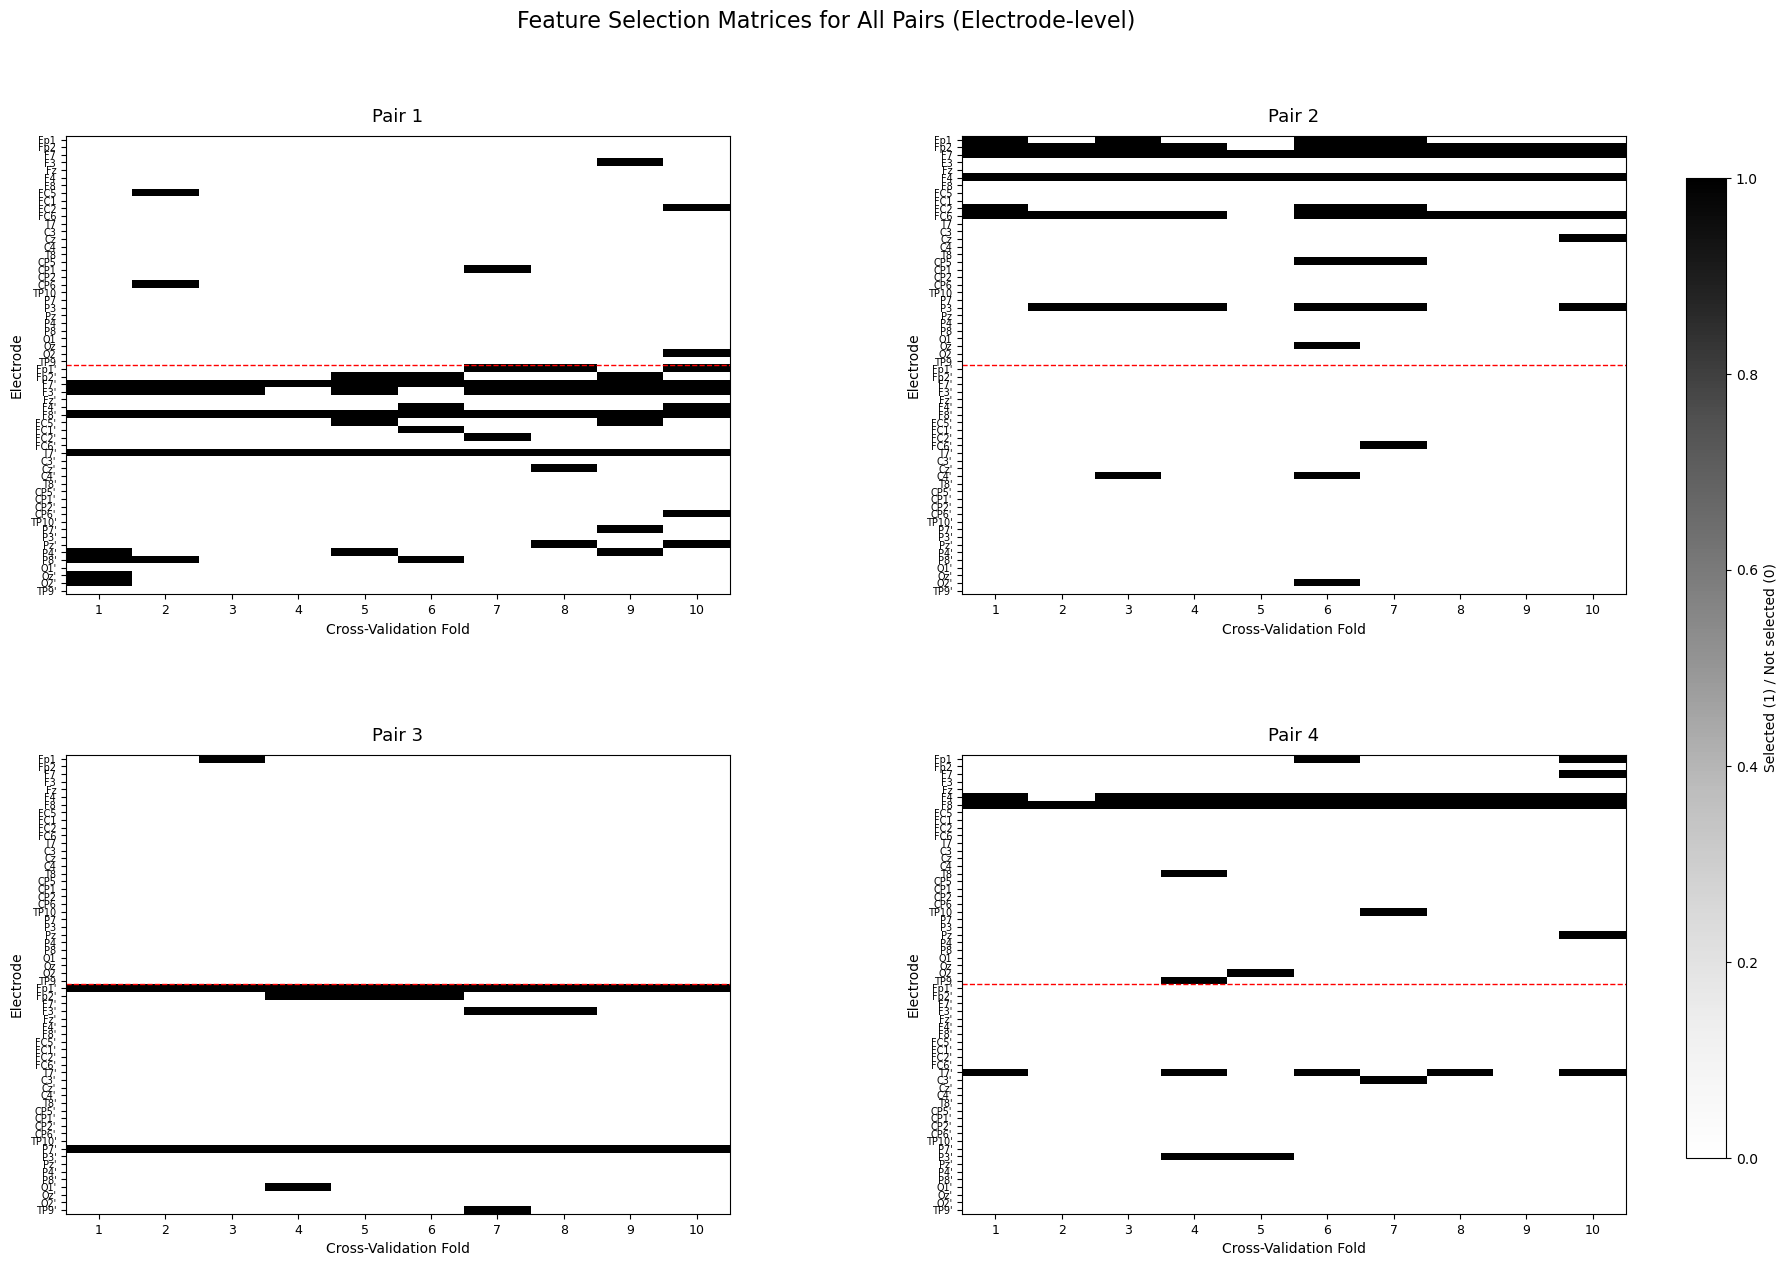

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# --- Electrode names (first 30 for person 1, next 30 for person 2) ---
electrodes = [
    # Participant 1 (1–30)
    "Fp1","Fp2","F7","F3","Fz","F4","F8","FC5","FC1","FC2",
    "FC6","T7","C3","Cz","C4","T8","CP5","CP1","CP2","CP6",
    "TP10","P7","P3","Pz","P4","P8","O1","Oz","O2","TP9",
    # Participant 2 (31–60)
    "Fp1'","Fp2'","F7'","F3'","Fz'","F4'","F8'","FC5'","FC1'","FC2'",
    "FC6'","T7'","C3'","Cz'","C4'","T8'","CP5'","CP1'","CP2'","CP6'",
    "TP10'","P7'","P3'","Pz'","P4'","P8'","O1'","Oz'","O2'","TP9'"
]

n_features = len(electrodes)
n_pairs = len(sfs_features)
rows, cols = 2, 2  # 2×2 grid for 4 pairs

# Wider figure and slightly taller for readability
fig, axes = plt.subplots(rows, cols, figsize=(20, 14), sharex=False, sharey=False)
axes = axes.flatten()

for p in range(n_pairs):
    n_folds = len(sfs_features[p])
    feature_matrix = np.zeros((n_features, n_folds))

    # Fill matrix: 1 if feature was selected in that fold
    for k, idx in enumerate(sfs_features[p]):
        feature_matrix[idx, k] = 1

    ax = axes[p]
    im = ax.imshow(feature_matrix, cmap='Greys', aspect='auto', interpolation='nearest')

    # Titles and labels
    ax.set_title(f'Pair {p+1}', fontsize=13, pad=10)
    ax.set_xlabel('Cross-Validation Fold', fontsize=10)
    ax.set_ylabel('Electrode', fontsize=10)

    # X-ticks
    ax.set_xticks(np.arange(n_folds))
    ax.set_xticklabels(np.arange(1, n_folds + 1), fontsize=9)

    # Y-ticks with electrode names
    ax.set_yticks(np.arange(0, n_features))
    ax.set_yticklabels(electrodes, fontsize=7)
    for label in ax.get_yticklabels():
        label.set_visible(True)   # Force visibility even if Matplotlib tries to hide them

    # Red dashed line to separate participants
    ax.axhline(y=29.5, color='red', linestyle='--', linewidth=1)

# Adjust spacing to give room for Y-labels and right-side colorbar
fig.subplots_adjust(left=0.12, right=0.9, wspace=0.35, hspace=0.35)

# Shared colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Selected (1) / Not selected (0)')

fig.suptitle('Feature Selection Matrices for All Pairs (Electrode-level)', fontsize=16, y=0.97)
plt.show()




In [22]:
# --- Loop through all pairs and folds to print selected features ---
for p in range(len(sfs_features)):
    print(f"\n============================")
    print(f"Pair {p+1}")
    print(f"============================")

    for k, idx in enumerate(sfs_features[p]):
        if idx is None or len(idx) == 0:
            print(f"  Fold {k+1}: No features selected.")
            continue

        selected = [electrodes[i] for i in idx]
        # Split into participant 1 vs 2
        part1 = [e for i, e in enumerate(selected) if "'" not in e]
        part2 = [e for i, e in enumerate(selected) if "'" in e]

        print(f"  Fold {k+1}: {len(selected)} features selected")
        print(f"    Participant 1: {', '.join(part1) if part1 else 'None'}")
        print(f"    Participant 2: {', '.join(part2) if part2 else 'None'}")



Pair 1
  Fold 1: 8 features selected
    Participant 1: None
    Participant 2: F7', F3', F8', T7', P4', P8', Oz', O2'
  Fold 2: 7 features selected
    Participant 1: FC5, CP6
    Participant 2: F7', F3', F8', T7', P8'
  Fold 3: 4 features selected
    Participant 1: None
    Participant 2: F7', F3', F8', T7'
  Fold 4: 3 features selected
    Participant 1: None
    Participant 2: F7', F8', T7'
  Fold 5: 7 features selected
    Participant 1: None
    Participant 2: Fp2', F7', F3', F8', FC5', T7', P4'
  Fold 6: 7 features selected
    Participant 1: None
    Participant 2: Fp2', F7', F4', F8', FC1', T7', P8'
  Fold 7: 7 features selected
    Participant 1: CP1
    Participant 2: Fp1', F7', F3', F8', FC2', T7'
  Fold 8: 7 features selected
    Participant 1: None
    Participant 2: Fp1', F7', F3', F8', T7', Cz', Pz'
  Fold 9: 9 features selected
    Participant 1: F3
    Participant 2: Fp2', F7', F3', F8', FC5', T7', P7', P4'
  Fold 10: 10 features selected
    Participant 1: FC2, O2


#### Conclusions based on the results

From the matrix plot we can see that some features are selected in every (or almost every) cross-validation fold, whereas others are more randomly selected. 

The list of the corresponding electrodes from 1-30 (for each person) is as follows: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, TP9, CP5, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2.
"F" refers to frontal electrodes; "T" = temporal; "C" = central; "P" = parietal; "O" = occipital; "FC" = fronto-central, etc. 

Looking at the matrices of selected features, do one participant's features seem to be more important for the prediction than the other's? 

Where are the most selected features situated?

In this experiment, in each pair one participant emerged as a leader and the other as a follower during the human-interaction. However, in the computer condition, each of the participants followed the computer. The participant in each pair whose features seem to be more important for the prediction was always the leader of the human-interaction. We speculate that the selected features thus tell us something about the neural mechanisms underlying leading behaviour. The follower participant is following in both the human and computer conditions, hence there is less difference in 10 Hz power modulation between the two conditions for this participant. The leading participant, however, follows the computer in the computer-condition, but focuses more on self-generated taps in the human-condition - hence emerging as a "leader" in the interaction.

What can you thus conclude about the neural mechanisms underlying leading behaviour, based on the selected features? 


The feature selection matrices reveal clear patterns in how the logistic regression model relied on specific electrodes across folds and pairs. In every pair, some electrodes were chosen consistently throughout most cross-validation folds, while others appeared only sporadically or not at all. This indicates that certain channels contained more stable information relevant for distinguishing between the two experimental conditions.

When comparing participants within each pair, there is a noticeable imbalance in several cases. In Pair 1 and Pair 3, the majority of selected electrodes belong to the second participant (features 30–60), while the first participant’s channels were rarely chosen. This suggests that the model found more predictive information in the second participant’s data. In contrast, Pair 2 and Pair 4 show a more mixed pattern, with both participants contributing to the classification, although the selections remain uneven between folds.

Across all pairs, the most frequently selected electrodes tend to cluster in central and fronto-central regions, with occasional contributions from parietal sites. These areas appear repeatedly across folds and pairs, suggesting that they carry more stable signals across participants. The presence of recurring patterns in the same subset of electrodes also points to a certain degree of consistency in how the model identifies relevant information, despite differences between pairs.

Taken together, the results indicate that the predictive power of the model is not evenly distributed between participants. In most cases, one participant contributes more to the classification than the other, which aligns with the idea that within each pair, one individual takes a more dominant or leading role during the interaction. This participant’s activity shows clearer and more reproducible patterns across folds, while the other’s remains less consistent.